# 07 - Create XGBoost Classifier Model

This notebook trains and optimizes an XGBoost classifier using hyperparameter tuning with Hyperopt, evaluates model performance with metrics and SHAP analysis, and saves the final model for deployment.

In [363]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [387]:
import pandas as pd
import pickle
import json
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score
import xgboost as xgb

import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import shap
from imblearn.over_sampling import SMOTE

import sys
sys.path.append('/path/to/bias-fairness-mvp/src')

from training_utils import save_experiment_metadata

import warnings
warnings.filterwarnings('ignore')  # Ignore all warnings

In [388]:
# Display all rows and columns
pd.set_option('display.max_colwidth', None)  # Show full content in each cell
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.max_columns', None)   # Show all columns

In [389]:
path = "../data/processed/"

In [390]:
# Read the datasets from parquet format
X_train = pd.read_parquet(f"{path}X_train.parquet")
X_test = pd.read_parquet(f"{path}X_test.parquet")
y_train = pd.read_parquet(f"{path}y_train.parquet").squeeze()
y_test = pd.read_parquet(f"{path}y_test.parquet").squeeze()

In [391]:
def save_training_columns_to_paths(X_train, file_paths):
    """
    Save X_train columns to multiple file paths as JSON.

    Parameters:
    X_train (pd.DataFrame): Training dataset.
    file_paths (list): List of file paths to save the JSON file.
    """
    columns = X_train.columns.tolist()

    for file_path in file_paths:
        try:
            # Ensure the directory exists
            os.makedirs(os.path.dirname(file_path), exist_ok=True)
            
            # Save the columns to the specified path
            with open(file_path, "w") as file:
                json.dump(columns, file)
            print(f"Training columns saved to {file_path}")
        except Exception as e:
            print(f"Error saving training columns to {file_path}: {e}")

# Define paths
file_paths = [
    "../app/models/features.json",
    "../models/features.json"
]

# Save the columns
save_training_columns_to_paths(X_train, file_paths)

Training columns saved to ../app/models/features.json
Training columns saved to ../models/features.json


In [368]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [369]:
# Apply SMOTE to the training data
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # 0.5 means minority/majority = 1/2
X_train, y_train = smote.fit_resample(X_train, y_train)

In [370]:
# Initialize and train XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss", early_stopping_rounds=10)

In [371]:
# Define the objective function for Hyperopt
# Optimize for recall to maximize correct predictions for class 0
def objective(params):
    model = xgb.XGBClassifier(
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        n_estimators=int(params['n_estimators']),
        subsample=params['subsample'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        colsample_bytree=params['colsample_bytree'],
        min_child_weight=params['min_child_weight'],
        scale_pos_weight=params['scale_pos_weight'],
        max_leaves=int(params['max_leaves']),
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    y_pred = model.predict(X_val)
    recall = recall_score(y_val, y_pred, pos_label=0, average='binary')
    return {'loss': -recall, 'status': STATUS_OK}

In [372]:
# Define the search space
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'n_estimators': hp.quniform('n_estimators', 50, 500, 10),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, 2),
    'reg_lambda': hp.loguniform('reg_lambda', -5, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 10),
    'max_leaves': hp.quniform('max_leaves', 10, 100, 10),
}

In [373]:
# Run Hyperopt
trials = Trials()
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)

100%|██████████| 50/50 [00:47<00:00,  1.05trial/s, best loss: -0.38235294117647056]


In [374]:
best_params

{'colsample_bytree': np.float64(0.817057424898969),
 'learning_rate': np.float64(0.5854283848859114),
 'max_depth': np.float64(9.0),
 'max_leaves': np.float64(60.0),
 'min_child_weight': np.float64(6.0),
 'n_estimators': np.float64(470.0),
 'reg_alpha': np.float64(2.354070983349471),
 'reg_lambda': np.float64(0.011180294865966361),
 'scale_pos_weight': np.float64(1.0506189826399186),
 'subsample': np.float64(0.6058867250040119)}

In [375]:
# Train the best model
best_xgb_model = xgb.XGBClassifier(
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    subsample=best_params['subsample'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    colsample_bytree=best_params['colsample_bytree'],
    min_child_weight=best_params['min_child_weight'],
    scale_pos_weight=best_params['scale_pos_weight'],
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)
best_xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

[0]	validation_0-logloss:0.51210
[1]	validation_0-logloss:0.49659
[2]	validation_0-logloss:0.48543
[3]	validation_0-logloss:0.48719
[4]	validation_0-logloss:0.48376
[5]	validation_0-logloss:0.47996
[6]	validation_0-logloss:0.48436
[7]	validation_0-logloss:0.48132
[8]	validation_0-logloss:0.48440
[9]	validation_0-logloss:0.47982
[10]	validation_0-logloss:0.47197
[11]	validation_0-logloss:0.47290
[12]	validation_0-logloss:0.47898
[13]	validation_0-logloss:0.47975
[14]	validation_0-logloss:0.48041
[15]	validation_0-logloss:0.47982
[16]	validation_0-logloss:0.47436
[17]	validation_0-logloss:0.47883
[18]	validation_0-logloss:0.47596
[19]	validation_0-logloss:0.47664
[20]	validation_0-logloss:0.47818
[21]	validation_0-logloss:0.47830
[22]	validation_0-logloss:0.47465
[23]	validation_0-logloss:0.47319
[24]	validation_0-logloss:0.47389
[25]	validation_0-logloss:0.47706
[26]	validation_0-logloss:0.47789
[27]	validation_0-logloss:0.48097
[28]	validation_0-logloss:0.48834
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.817057424898969), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None,
              learning_rate=np.float64(0.5854283848859114), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=np.float64(6.0), missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=470,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [376]:
# Predict on test data
y_pred = best_xgb_model.predict(X_test)

In [377]:
# Generate classification report
report = classification_report(y_test, y_pred)

# Display the report in a structured format
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.32      0.34        57
           1       0.85      0.88      0.87       256

    accuracy                           0.78       313
   macro avg       0.61      0.60      0.61       313
weighted avg       0.77      0.78      0.77       313



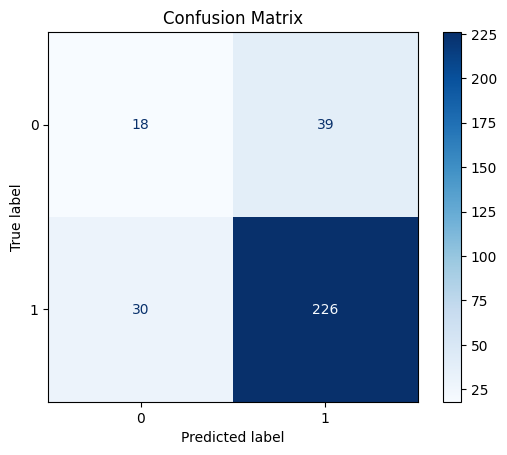

In [378]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_xgb_model.classes_)
disp.plot(cmap="Blues")
disp.ax_.set_title("Confusion Matrix")
plt.show()

In [379]:
model_name = "XGBoost"
parameters = best_params
comments = "SMOTE"

In [380]:
# Save experiment metadata
file_path = "../models/experiment_tracker.csv"
save_experiment_metadata(file_path, model_name, parameters, comments, y_test, y_pred)

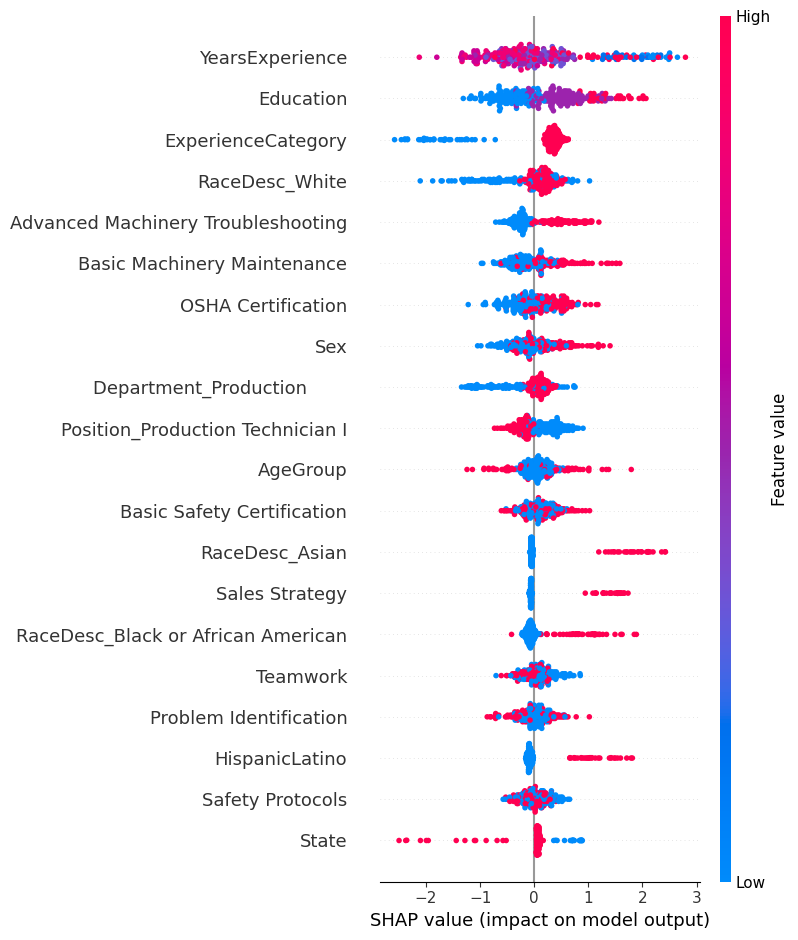

In [381]:
# SHAP Analysis
explainer = shap.Explainer(best_xgb_model, X_train)
shap_values = explainer(X_test)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test)

**Load params for best model**

In [382]:
params = {
    'colsample_bytree': float(0.8058588548294551),
    'learning_rate': float(0.6560424536397838),
    'max_depth': int(8.0),
    'min_child_weight': float(1.0),
    'n_estimators': int(380.0),
    'reg_alpha': float(0.006949423263346376),
    'reg_lambda': float(1.844521759258614),
    'scale_pos_weight': float(1.4055718859295996),
    'subsample': float(0.8564398834963964),
    'random_state': 42,  # Adding random_state for reproducibility
    'use_label_encoder': False,  # Suppress XGBoost label encoding warning
    'eval_metric': 'logloss'  # Set the evaluation metric
}

In [383]:
# Initialize and train the XGBoost model
xgb_model = xgb.XGBClassifier(**params)

# Train the model on training data
xgb_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = xgb_model.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.37      0.39        57
           1       0.86      0.88      0.87       256

    accuracy                           0.79       313
   macro avg       0.64      0.63      0.63       313
weighted avg       0.78      0.79      0.78       313

Confusion Matrix:
[[ 21  36]
 [ 30 226]]


In [384]:
# Save the XGBoost model as a pickle file
model_path = "../models/xgb_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(xgb_model, f)

print(f"Model saved to {model_path}")

Model saved to ../models/xgb_model.pkl
